In [14]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 10, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.800781
Train Epoch: 1 [1280/60000 (2%)]	Loss: 322.319275
Train Epoch: 1 [2560/60000 (4%)]	Loss: 238.075089
Train Epoch: 1 [3840/60000 (6%)]	Loss: 217.480148
Train Epoch: 1 [5120/60000 (9%)]	Loss: 207.814041
Train Epoch: 1 [6400/60000 (11%)]	Loss: 210.372253
Train Epoch: 1 [7680/60000 (13%)]	Loss: 206.411575
Train Epoch: 1 [8960/60000 (15%)]	Loss: 198.051224
Train Epoch: 1 [10240/60000 (17%)]	Loss: 196.847107
Train Epoch: 1 [11520/60000 (19%)]	Loss: 188.627228
Train Epoch: 1 [12800/60000 (21%)]	Loss: 184.369156
Train Epoch: 1 [14080/60000 (23%)]	Loss: 183.649902
Train Epoch: 1 [15360/60000 (26%)]	Loss: 175.880432
Train Epoch: 1 [16640/60000 (28%)]	Loss: 163.250214
Train Epoch: 1 [17920/60000 (30%)]	Loss: 168.123962
Train Epoch: 1 [19200/60000 (32%)]	Loss: 161.854095
Train Epoch: 1 [20480/60000 (34%)]	Loss: 164.584656
Train Epoch: 1 [21760/60000 (36%)]	Loss: 158.747131
Train Epoch: 1 [23040/60000 (38%)]	Loss: 159.783020
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [19200/60000 (32%)]	Loss: 110.536209
Train Epoch: 4 [20480/60000 (34%)]	Loss: 116.669022
Train Epoch: 4 [21760/60000 (36%)]	Loss: 109.946167
Train Epoch: 4 [23040/60000 (38%)]	Loss: 106.806717
Train Epoch: 4 [24320/60000 (41%)]	Loss: 113.712021
Train Epoch: 4 [25600/60000 (43%)]	Loss: 114.287399
Train Epoch: 4 [26880/60000 (45%)]	Loss: 111.832962
Train Epoch: 4 [28160/60000 (47%)]	Loss: 111.418259
Train Epoch: 4 [29440/60000 (49%)]	Loss: 109.207481
Train Epoch: 4 [30720/60000 (51%)]	Loss: 113.730743
Train Epoch: 4 [32000/60000 (53%)]	Loss: 110.521347
Train Epoch: 4 [33280/60000 (55%)]	Loss: 111.529205
Train Epoch: 4 [34560/60000 (58%)]	Loss: 109.040588
Train Epoch: 4 [35840/60000 (60%)]	Loss: 110.714279
Train Epoch: 4 [37120/60000 (62%)]	Loss: 113.565536
Train Epoch: 4 [38400/60000 (64%)]	Loss: 109.106628
Train Epoch: 4 [39680/60000 (66%)]	Loss: 112.441658
Train Epoch: 4 [40960/60000 (68%)]	Loss: 115.712234
Train Epoch: 4 [42240/60000 (70%)]	Loss: 110.534798
Train Epoch:

Train Epoch: 7 [37120/60000 (62%)]	Loss: 106.615013
Train Epoch: 7 [38400/60000 (64%)]	Loss: 104.458656
Train Epoch: 7 [39680/60000 (66%)]	Loss: 106.158409
Train Epoch: 7 [40960/60000 (68%)]	Loss: 110.386833
Train Epoch: 7 [42240/60000 (70%)]	Loss: 109.205490
Train Epoch: 7 [43520/60000 (72%)]	Loss: 106.034851
Train Epoch: 7 [44800/60000 (75%)]	Loss: 105.851952
Train Epoch: 7 [46080/60000 (77%)]	Loss: 109.074837
Train Epoch: 7 [47360/60000 (79%)]	Loss: 110.380646
Train Epoch: 7 [48640/60000 (81%)]	Loss: 107.348526
Train Epoch: 7 [49920/60000 (83%)]	Loss: 113.428726
Train Epoch: 7 [51200/60000 (85%)]	Loss: 110.138596
Train Epoch: 7 [52480/60000 (87%)]	Loss: 108.097610
Train Epoch: 7 [53760/60000 (90%)]	Loss: 108.186783
Train Epoch: 7 [55040/60000 (92%)]	Loss: 105.318085
Train Epoch: 7 [56320/60000 (94%)]	Loss: 104.586700
Train Epoch: 7 [57600/60000 (96%)]	Loss: 108.735779
Train Epoch: 7 [58880/60000 (98%)]	Loss: 109.964890
====> Epoch: 7 Average loss: 107.9816
====> Test set loss: 107.3

Train Epoch: 10 [57600/60000 (96%)]	Loss: 107.381454
Train Epoch: 10 [58880/60000 (98%)]	Loss: 103.547523
====> Epoch: 10 Average loss: 106.3933
====> Test set loss: 105.7021


In [18]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np

batch_size = 100
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

In [19]:
print(encoder)

In [22]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu',
name="decoder_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid',
name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")

output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

def vae_loss(x, x_decoded_mean, z_log_var, z_mean,
    original_dim=original_dim):
    xent_loss = original_dim * objectives.binary_crossentropy(
        x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
        axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

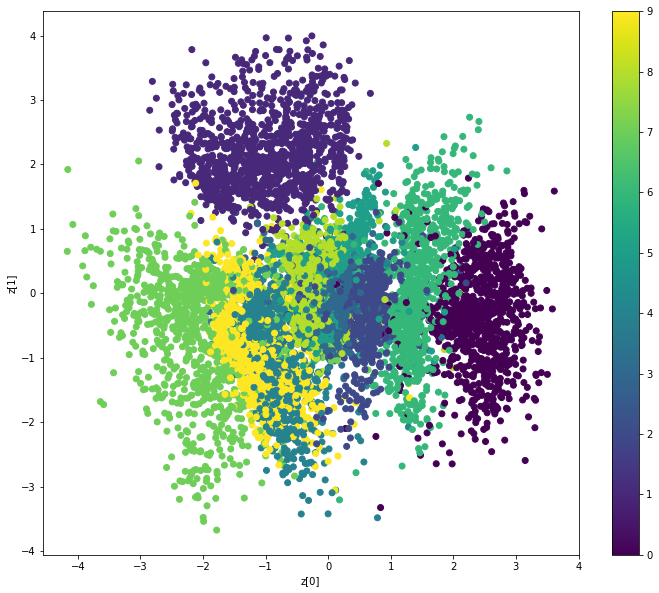

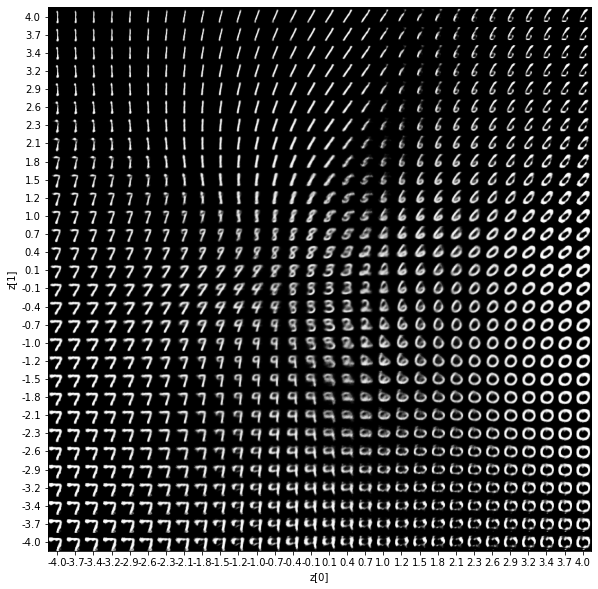

In [1]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load h5 model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use mse loss instead of binary cross entropy (default)"
    parser.add_argument("-m",
                        "--mse",
                        help=help_, action='store_true')
    args, unknown = parser.parse_known_args()
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.mse:
        reconstruction_loss = mse(inputs, outputs)
    else:
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    if args.weights:
        vae.load_weights(args.weights)
    else:
        # train the autoencoder
        vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
        vae.save_weights('vae_mlp_mnist.h5')

    plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [ ]:
# example from https://github.com/pytorch/examples/blob/master/vae/main.py
# commented and type annotated by Charl Botha <cpbotha@vxlabs.com>

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# changed configuration to this instead of argparse for easier interaction
CUDA = True
SEED = 1
BATCH_SIZE = 1
LOG_INTERVAL = 10
EPOCHS = 3

# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20
ZDIMS = 20

# I do this so that the MNIST dataset is downloaded where I want it

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

# Download or load downloaded MNIST dataset
# shuffle data at every epoch
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# Same for test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        # 28 x 28 pixels = 784 input pixels, 400 outputs
        self.fc1 = nn.Linear(784, 400)
        # rectified linear unit layer from 400 to 400
        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(400, ZDIMS)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections

        # DECODER
        # from bottleneck to hidden 400
        self.fc3 = nn.Linear(ZDIMS, 400)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        """Input vector x -> fully connected 1 -> ReLU -> (fully connected
        21, fully connected 22)

        Parameters
        ----------
        x : [128, 784] matrix; 128 digits of 28x28 pixels each

        Returns
        -------

        (mu, logvar) : ZDIMS mean units one for each latent dimension, ZDIMS
            variance units one for each latent dimension

        """

        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        """THE REPARAMETERIZATION IDEA:

        For each training sample (we get 128 batched at a time)

        - take the current learned mu, stddev for each of the ZDIMS
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians

        Parameters
        ----------
        mu : [128, ZDIMS] mean matrix
        logvar : [128, ZDIMS] variance matrix

        Returns
        -------

        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.

        """

        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation
            std = logvar.mul(0.5).exp_()  # type: Variable
            # - std.data is the [128,ZDIMS] tensor that is wrapped by std
            # - so eps is [128,ZDIMS] with all elements drawn from a mean 0
            #   and stddev 1 normal distribution that is 128 samples
            #   of random ZDIMS-float vectors
            eps = Variable(std.data.new(std.size()).normal_())
            # - sample from a normal distribution with standard
            #   deviation = std and mean = mu by multiplying mean 0
            #   stddev 1 sample with desired std and mu, see
            #   https://stats.stackexchange.com/a/16338
            # - so we have 128 sets (the batch) of random ZDIMS-float
            #   vectors sampled from normal distribution with learned
            #   std and mu for the current input
            return eps.mul(std).add_(mu)

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if CUDA:
    model.cuda()


def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = Variable(torch.randn(64, ZDIMS))
    if CUDA:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.707579
Train Epoch: 1 [10/60000 (0%)]	Loss: 0.495614
Train Epoch: 1 [20/60000 (0%)]	Loss: 0.434785
Train Epoch: 1 [30/60000 (0%)]	Loss: 0.365623
Train Epoch: 1 [40/60000 (0%)]	Loss: 0.225908
Train Epoch: 1 [50/60000 (0%)]	Loss: 0.242513
Train Epoch: 1 [60/60000 (0%)]	Loss: 0.290183
Train Epoch: 1 [70/60000 (0%)]	Loss: 0.304172
Train Epoch: 1 [80/60000 (0%)]	Loss: 0.366152
Train Epoch: 1 [90/60000 (0%)]	Loss: 0.265337
Train Epoch: 1 [100/60000 (0%)]	Loss: 0.203357
Train Epoch: 1 [110/60000 (0%)]	Loss: 0.294405
Train Epoch: 1 [120/60000 (0%)]	Loss: 0.223995
Train Epoch: 1 [130/60000 (0%)]	Loss: 0.279140
Train Epoch: 1 [140/60000 (0%)]	Loss: 0.264926
Train Epoch: 1 [150/60000 (0%)]	Loss: 0.201361
Train Epoch: 1 [160/60000 (0%)]	Loss: 0.276660
Train Epoch: 1 [170/60000 (0%)]	Loss: 0.303092
Train Epoch: 1 [180/60000 (0%)]	Loss: 0.341753
Train Epoch: 1 [190/60000 (0%)]	Loss: 0.313988
Train Epoch: 1 [200/60000 (0%)]	Loss: 0.231436
Train Epoch: 1 [210/6000

Train Epoch: 1 [1750/60000 (3%)]	Loss: 0.302933
Train Epoch: 1 [1760/60000 (3%)]	Loss: 0.088767
Train Epoch: 1 [1770/60000 (3%)]	Loss: 0.187516
Train Epoch: 1 [1780/60000 (3%)]	Loss: 0.173402
Train Epoch: 1 [1790/60000 (3%)]	Loss: 0.204384
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.187922
Train Epoch: 1 [1810/60000 (3%)]	Loss: 0.214974
Train Epoch: 1 [1820/60000 (3%)]	Loss: 0.242380
Train Epoch: 1 [1830/60000 (3%)]	Loss: 0.176626
Train Epoch: 1 [1840/60000 (3%)]	Loss: 0.228164
Train Epoch: 1 [1850/60000 (3%)]	Loss: 0.255247
Train Epoch: 1 [1860/60000 (3%)]	Loss: 0.186366
Train Epoch: 1 [1870/60000 (3%)]	Loss: 0.235099
Train Epoch: 1 [1880/60000 (3%)]	Loss: 0.189506
Train Epoch: 1 [1890/60000 (3%)]	Loss: 0.184068
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.236879
Train Epoch: 1 [1910/60000 (3%)]	Loss: 0.269457
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.278067
Train Epoch: 1 [1930/60000 (3%)]	Loss: 0.106160
Train Epoch: 1 [1940/60000 (3%)]	Loss: 0.238377
Train Epoch: 1 [1950/60000 (3%)]	Loss: 0